In [1]:
import requests
import numpy as np
import json
import pandas as pd
import ibmseti
import collections
import scipy.io
import matplotlib.pyplot as plt
import commonutils as cu

In [2]:
r = requests.get('https://dal.objectstorage.open.softlayer.com/v1/AUTH_cdbef52bdf7a449c96936e1071f0a46b/simsignals_files/public_list_headers_3april_2017.txt')

In [3]:
fileList = r.text.split('\n')[:-1]
fileListJSON = [json.loads(entry) for entry in fileList]
fileListJSON[0]

{u'file_name': u'00069203-0824-4136-9c99-b9f68672f23d.dat',
 u'signal_classification': u'squigglesquarepulsednarrowband',
 u'uuid': u'00069203-0824-4136-9c99-b9f68672f23d'}

In [5]:
# Taking a subset of signals to download and play around with
subset = dict.fromkeys(list(np.unique([ str(file['signal_classification']) for file in fileListJSON])))
for key in subset.keys(): subset[key] = []
nSignals = 10
i = 0
while any( [len(v)<nSignals for v in subset.values()] ):
    current = (str(fileListJSON[i]['signal_classification']),str(fileListJSON[i]['file_name']))
    if len(subset[current[0]])<nSignals:
        subset[current[0]].append(current[1])
    i = i + 1

In [6]:
# For each type, download all files, and extract and save complex signal and spectrogram
base_url = 'https://dal.objectstorage.open.softlayer.com/v1/AUTH_cdbef52bdf7a449c96936e1071f0a46b'
container = 'simsignals'

subsetComplexSignals = collections.defaultdict(list)
subsetSpectrograms = collections.defaultdict(list)

for (signalType,signalList) in subset.items():
    print signalType
    for fname in signalList:
        r = requests.get('{}/{}/{}'.format(base_url,container,fname))
        aca = ibmseti.compamp.SimCompamp(r.content)
        subsetComplexSignals[signalType].append(aca.complex_data().reshape(129,6144))
        subsetSpectrograms[signalType].append(aca.get_spectrogram())

noise
squiggle
narrowbanddrd
brightpixel
narrowband
squigglesquarepulsednarrowband
squarepulsednarrowband


In [ ]:
# Saving numpy files 
np.save('complexSignalsSubset.npy',subsetComplexSignals)
np.save('specSubset.npy',subsetSpectrograms)

# Saving to separate matlab files for each signal type
# for key in subset.keys():
#     a = np.stack(subsetComplexSignals[key])
#     b = np.stack(subsetSpectrograms[key])
#     scipy.io.savemat('{}{}'.format(key,'Signal.mat'),{'{}{}'.format(key,'Signal'):a})
#     scipy.io.savemat('{}{}'.format(key,'Spec.mat'),{'{}{}'.format(key,'Spec'):b})

In [2]:
# Loading in saved sample data files 
subsetComplexSignals = np.load('complexSignalsSubset.npy')[()]
subsetSpectrograms = np.load('specSubset.npy')[()]

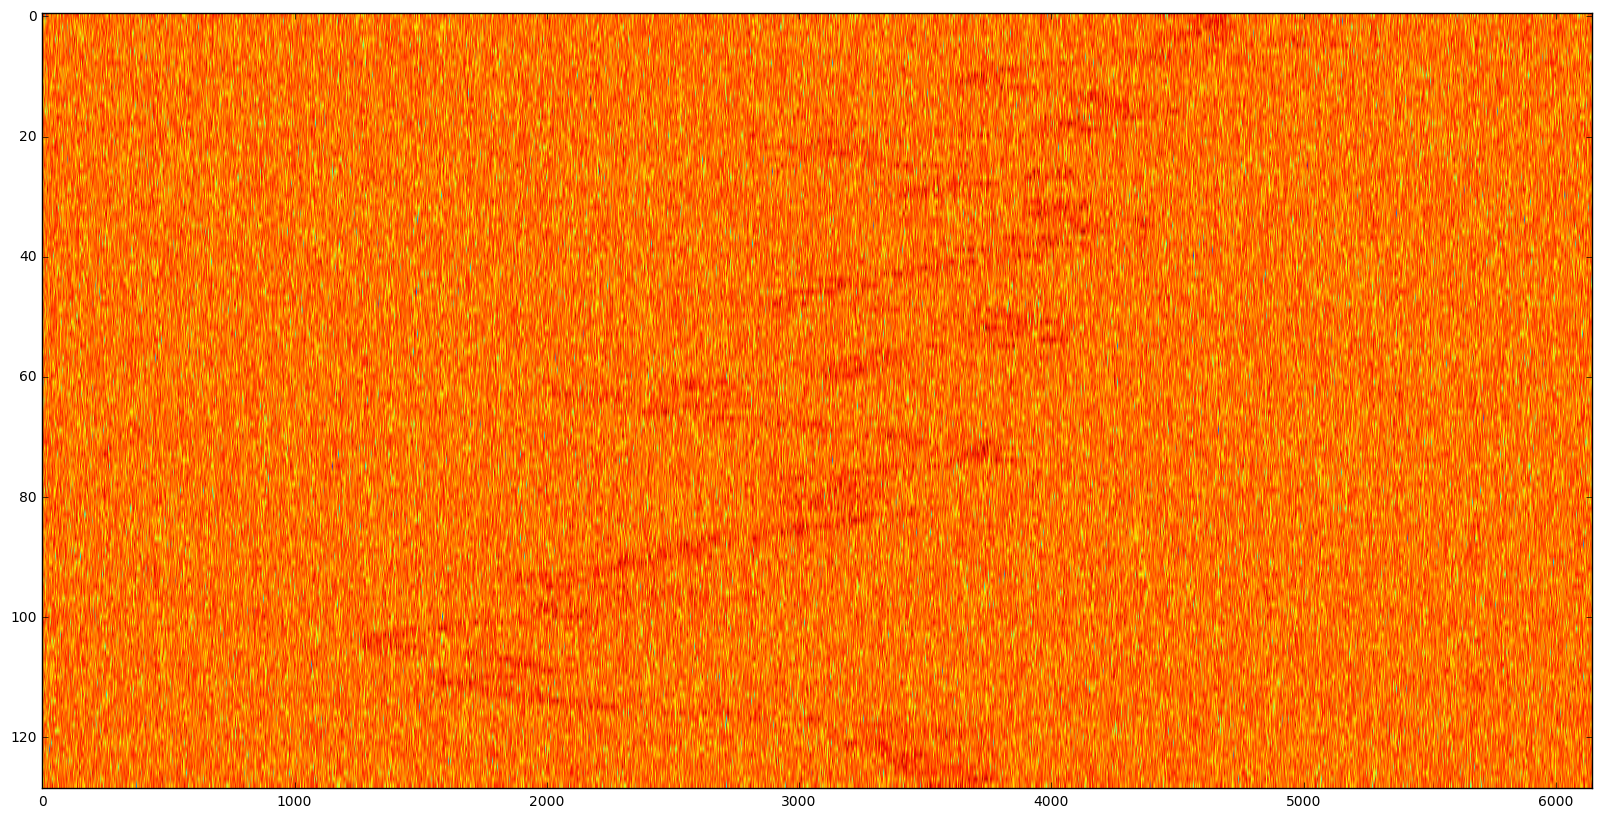

In [20]:
# spec = subsetSpectrograms['narrowband'][1]
spec = subsetSpectrograms['squiggle'][1]
# spec = subsetSpectrograms['squigglesquarepulsednarrowband'][2]
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(np.log(spec), aspect = 0.5*float(spec.shape[1]) / spec.shape[0])
plt.show()

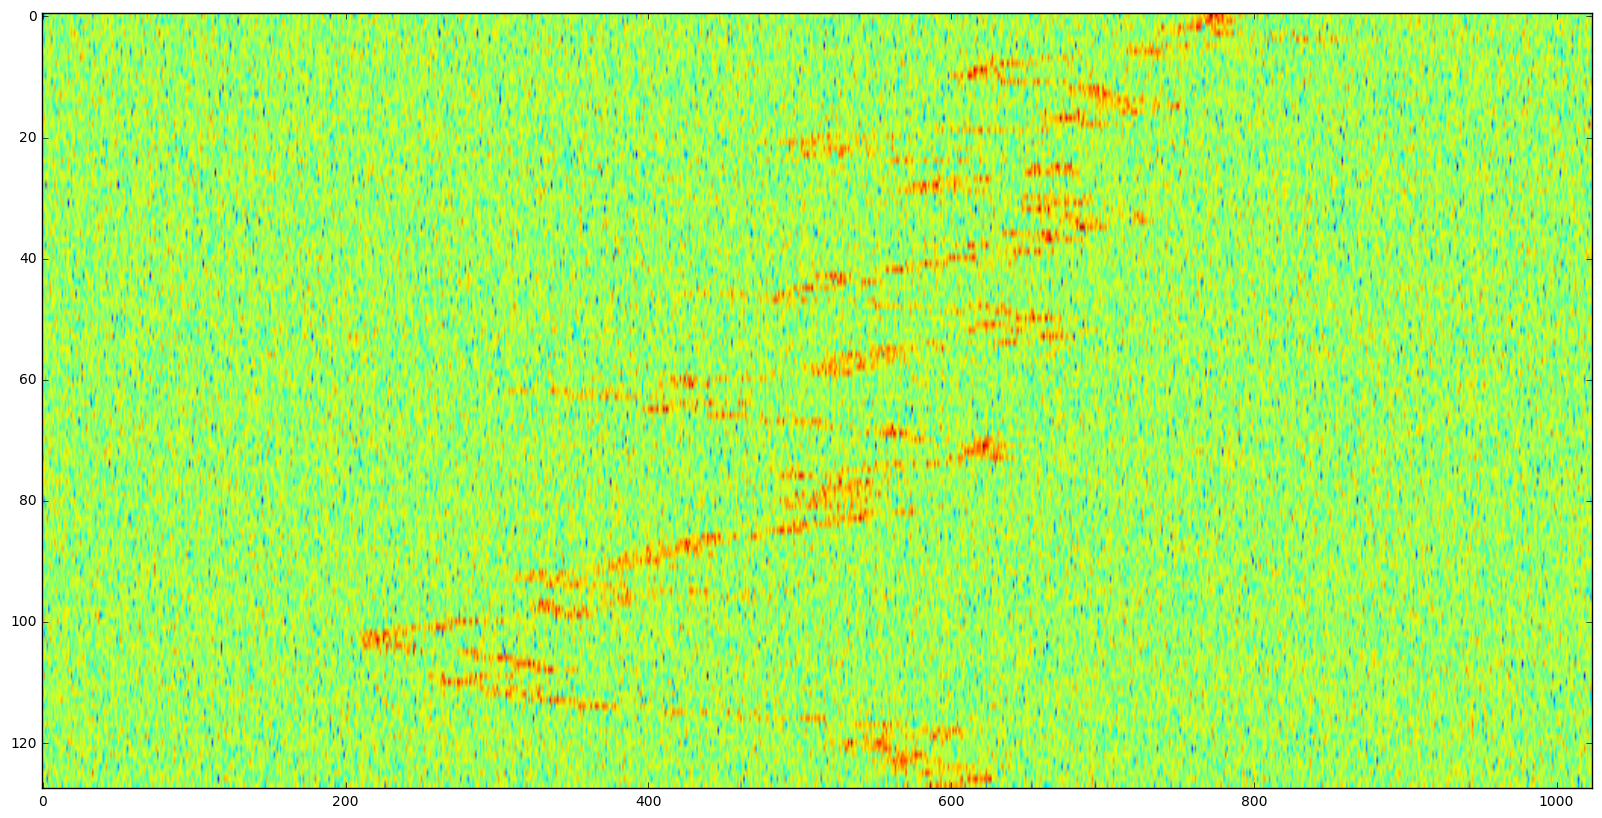

In [21]:
# Using code from https://gist.github.com/derricw/95eab740e1b08b78c03f, reducing along x axis
# Seeing how much file can be reduced in size. Ignoring first row to make it 128x6144
# Then factoring down on x-axis by 8
spec_reduced = cu.nputils.bin_ndarray(spec[1:,:],(128,1024),operation='average')

fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(np.log(spec_reduced), aspect = 0.5*float(spec_reduced.shape[1]) / spec_reduced.shape[0])
plt.show()

In [9]:
## Downloading and saving all files to local storage


(129, 6144)